#Imports

In [ ]:
# Standard IPython notebook imports
%matplotlib inline

! apt-get install default-jre

import os
from io import StringIO

import graphviz
import httpimport
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import scipy.stats as sstats
import seaborn as sns
import sklearn.ensemble
import sklearn.tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm_notebook
import urllib.request

# Memory profiling
!pip install memory_profiler
%load_ext memory_profiler

Reading package lists... Done
Building dependency tree       
Reading state information... Done
default-jre is already the newest version (2:1.11-68ubuntu1~18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


#Data preparation

##Dataset loading

From year 2015 there are ~1 million records available, ~843k from 2016. As for the monthly data it goes like this:
```
03_2019 44398
04_2019 192394
05_2019 174104
06_2019 330388
07_2019 308896
08_2019 274587
09_2019 200461
10_2019 188419
11_2019 110079
12_2019 50062
01_2020 39926
```

In [ ]:
PLACES_URL = 'https://www.wroclaw.pl/open-data/datastore/dump/42eea6ec-43c3-4d13-aa77-a93394d6165a'

def normalize_place(place):
    return place.replace(' - ', ' / ').lower()

# places that probable are not real (placeholders etc.):
# 'Poza stacją', '.GOTOWE DO REZERWACJI', 'NIOL test', '.RELOKACYJNA', '# Rowery skardzione Wrocław 2014', 'MAHLE'
place_series = pd.read_csv(PLACES_URL, usecols = ['name']).name

In [ ]:
URLS = {
    '2015': 'https://www.wroclaw.pl/open-data/dataset/a646ce34-b24a-4f5c-8174-71dfc1bd2d0b/resource/64a623d6-2a98-4660-be83-85354e94bca3/download/wypozyczenia_wrm-sezon2015.xlsx',
    '2016': 'https://www.wroclaw.pl/open-data/dataset/a646ce34-b24a-4f5c-8174-71dfc1bd2d0b/resource/276306b4-9ab7-4036-a7e3-ee7af3b485d5/download/wypozyczenia_wrm-sezon2016.xlsx',
    '03_2019': 'https://www.wroclaw.pl/open-data/dataset/a646ce34-b24a-4f5c-8174-71dfc1bd2d0b/resource/30d9e087-bafd-441e-aa09-f20a11fc60f5/download/historia_przejazdow_2019-03.csv',
    '04_2019': 'https://www.wroclaw.pl/open-data/dataset/a646ce34-b24a-4f5c-8174-71dfc1bd2d0b/resource/1175d9da-3ae2-4ebc-8b1c-1f13fb5bf7b0/download/historia_przejazdow_2019-04.csv',
    '05_2019': 'https://www.wroclaw.pl/open-data/dataset/a646ce34-b24a-4f5c-8174-71dfc1bd2d0b/resource/a24161cc-3974-4741-9ddf-fe8663fa641b/download/historia_przejazdow_2019-05.csv',
    '06_2019': 'https://www.wroclaw.pl/open-data/dataset/a646ce34-b24a-4f5c-8174-71dfc1bd2d0b/resource/4a63e438-2c73-4fe3-9599-21c319887a85/download/historia_przejazdow_2019-06.csv',
    '07_2019': 'https://www.wroclaw.pl/open-data/dataset/a646ce34-b24a-4f5c-8174-71dfc1bd2d0b/resource/aa5da036-daad-480b-93c2-f1fbfda9b663/download/historia_przejazdow_2019-07.csv',
    '08_2019': 'https://www.wroclaw.pl/open-data/dataset/a646ce34-b24a-4f5c-8174-71dfc1bd2d0b/resource/5812256f-d0a5-43dd-850b-b8e8d13fe557/download/historia_przejazdow_2019-08.csv',
    '09_2019': 'https://www.wroclaw.pl/open-data/dataset/a646ce34-b24a-4f5c-8174-71dfc1bd2d0b/resource/673bec03-a145-46ee-a302-9eeabec53728/download/historia_przejazdow_2019-09.csv',
    '10_2019': 'https://www.wroclaw.pl/open-data/dataset/a646ce34-b24a-4f5c-8174-71dfc1bd2d0b/resource/31b7a6c6-d0e1-4818-9677-f66cb4809803/download/historia_przejazdow_2019-10.csv',
    '11_2019': 'https://www.wroclaw.pl/open-data/dataset/a646ce34-b24a-4f5c-8174-71dfc1bd2d0b/resource/12c60a15-43d9-4c39-88f0-0c7c9a1dbdc9/download/historia_przejazdow_2019-11.csv',
    '12_2019': 'https://www.wroclaw.pl/open-data/dataset/a646ce34-b24a-4f5c-8174-71dfc1bd2d0b/resource/ca84c93c-17c3-466e-b064-82ad22481721/download/historia_przejazdow_2019-12.csv',
    '01_2020': 'https://www.wroclaw.pl/open-data/dataset/a646ce34-b24a-4f5c-8174-71dfc1bd2d0b/resource/0350bb51-6c66-416a-bb09-db0dbc86aacd/download/historia_przejazdow_2020-01.csv',
}

METEO_URLS = {
    '03_2019' : 'https://www.math.uni.wroc.pl/~mzalew/meteo/weather_reduced2_2019-03.csv',
    '04_2019' : 'https://www.math.uni.wroc.pl/~mzalew/meteo/weather_reduced2_2019-04.csv',
    '05_2019' : 'https://www.math.uni.wroc.pl/~mzalew/meteo/weather_reduced2_2019-05.csv',
    '06_2019' : 'https://www.math.uni.wroc.pl/~mzalew/meteo/weather_reduced2_2019-06.csv',
    '07_2019' : 'https://www.math.uni.wroc.pl/~mzalew/meteo/weather_reduced2_2019-07.csv',
    '08_2019' : 'https://www.math.uni.wroc.pl/~mzalew/meteo/weather_reduced2_2019-08.csv',
    '09_2019' : 'https://www.math.uni.wroc.pl/~mzalew/meteo/weather_reduced2_2019-09.csv',
    '10_2019' : 'https://www.math.uni.wroc.pl/~mzalew/meteo/weather_reduced2_2019-10.csv',
    '11_2019' : 'https://www.math.uni.wroc.pl/~mzalew/meteo/weather_reduced2_2019-11.csv',
    '12_2019' : 'https://www.math.uni.wroc.pl/~mzalew/meteo/weather_reduced2_2019-12.csv',
    '01_2020' : 'https://www.math.uni.wroc.pl/~mzalew/meteo/weather_reduced2_2020-01.csv',
}

Helper function for accessing CSVs. Caches them on disk for faster reloads. For the case of Excel documents, converts them to CSV (from ~75s load time to ~2s !).

In [ ]:
for key in URLS:
    path = f"csv_cache/{key}.csv_cleaned"
    if os.path.exists(path):
        os.remove(path)

In [ ]:
def get_data(key, place_as_categorical = True, clean_up_places = False):
    usecols = ['uid', 'bike_number', 'start_time', 'end_time', 'rental_place', 'return_place']

    # get_data will accept only known (that is, from PLACES_URL document) locations
    local_place_series = place_series
    if clean_up_places:
        local_place_series = place_series.apply(normalize_place)

    place_dtype = pd.CategoricalDtype(list(local_place_series))

    root = "csv_cache"
    path = f"{root}/{key}.csv"

    if len(URLS[key].split('.')) < 2 or URLS[key].split('.')[-1] not in ["csv", "xlsx"]:
        print("Unexpected file extension")
        return None

    if not os.path.exists(path):
        download_path = path

        if URLS[key].endswith(".xlsx"):
            download_path = f"{path}.xlsx"

        if not os.path.exists(root):
            os.mkdir(root)

        urllib.request.urlretrieve(URLS[key], download_path)

        if URLS[key].endswith(".xlsx"):
            pd.read_excel(download_path).to_csv(path, index = False)

    if clean_up_places:
        cleaned_path = f"{root}/{key}.csv_cleaned"
        if not os.path.exists(cleaned_path):
            df = pd.read_csv(path)
            to_usecols = dict(zip(df.columns, ['IGNORED: Unnamed: 0'] + usecols))
            from_usecols = dict(zip(['IGNORED: Unnamed: 0'] + usecols, df.columns))

            df.rename(to_usecols, axis = 'columns', inplace = True)

            df['rental_place'] = df.rental_place.apply(normalize_place)
            df['return_place'] = df.return_place.apply(normalize_place)

            df.rename(from_usecols, axis = 'columns', inplace = True)
            df.to_csv(cleaned_path, index = False)
        
        path = cleaned_path

    return pd.read_csv(
        path, 
        names = ['IGNORED: Unnamed: 0'] + usecols, header = 0,
        usecols = usecols,
        parse_dates = ['start_time', 'end_time'],
        dtype = {'rental_place': place_dtype, 'return_place': place_dtype} if place_as_categorical else {}
    )

### Count duplicate rows in pd.DataFrame
# def fun(key):
#     ls = [g for _, g in get_data(key).groupby("uid") if len(g) > 1]
#     if len(ls) > 0:
#         return pd.concat(ls).shape[0]
#     return 0
# b

Weather data

In [ ]:
def get_meteo(date):
    return pd.read_csv(METEO_URLS[date]).drop(columns=['Unnamed: 0']).rename(columns = { 
        'Wilgotność względna [%]': 'relative_humidity',
        'Temperatura powietrza [°C]': 'temperature',
        'Prędkość wiatru  [m/s]': 'wind_speed'
    })

##Convert rental records into stay records
stay -- bike (probably) stayed at the same place for some time

Source data has shape:

index|uid|bike_number|start_time|end_time|rental_place|return_place
-----|---|-----------|----------|--------|------------|------------

To predict station occupancy, we would like to have data shaped something like this:

data_time|weather data etc.|place|number of bikes
---------|-----------------|-----|---------------

where date_time will be probably split into month, day of month and day of week columns which will be then 1-hot encoded

<br />

For now, let's create simple transformation of source data into following shape

bike_number|start_time|end_time|place
-----------|----------|--------|-----

which represents time ranges in which given bike stayed in the same place. This is kind of an inverse of what source data tells us.

In [ ]:
def make_stay_df(df):
    ### 1. Sort rentals by bike number and time of rental.
    ###    As the result, succeeding rentals will (usually) correspond to next rental of the same bike.
    ###    We join succeeding rentals as preparation for next step.
    df_sorted = df.sort_values(['bike_number', 'start_time']).drop_duplicates(ignore_index=True)

    df_left = df_sorted[:-1].add_prefix('left_').reset_index(drop = True)
    df_right = df_sorted[1:].add_prefix('right_').reset_index(drop = True)
    # types of uids and bike_numbers *used to* get changed into float64s, need further investigation but for now left as-is
    df_concat = pd.concat([df_left, df_right], axis = 'columns')

    ### 2. Having obtained succeeding bike rental events, we check if they are
    ###    indeed rentals of the same bike, if they are from same location
    ###    and if the place is provided at all.
    minimal_conditions = (df_concat.left_bike_number == df_concat.right_bike_number) \
                       & (df_concat.left_return_place == df_concat.right_rental_place) # same bike & same spot
    main_conditions = minimal_conditions \
                    & (~df_concat.left_return_place.isna() & ~df_concat.right_rental_place.isna()) # places aren't NAs
    sanity_conditions = main_conditions \
                      & (df_concat.left_end_time <= df_concat.right_start_time) # time coherency (sanity check)

    new_columns = {
        "left_bike_number": "bike_number", 
        "left_end_time": "start_time", 
        "right_start_time": "end_time",
        "left_return_place": "place"
    }
    stay_df = df_concat.loc[main_conditions,new_columns.keys()].rename(columns = new_columns).reset_index(drop = True)

    return stay_df

Now we can obtain amout of bikes at each station at different times (for instance, every 15 minutes).

timestamp|place_A|place_B|place_C|...
---------|-------|-------|-------|---

Then, we convert from wide representation of number of bikes on stations into long one:

timestamp|place|bikes_count
---------|-----|-----------

In [ ]:
def make_wide_occupancy_df(stay_df, freq, hours_limit):
    ### 3. Now that we have info about where each bike stayed
    ###    and during which time period, we can obtain station occupancy.
    ###    To do so we first 1-hot encode occupied station, then for given
    ###    timestamp sum occupancies at all stations.
    ###    Finally, station/place is melt back from 1-hot encoding.

    place_cols = [ "place_" + p for p in list(place_series) ]
    dummies_df = pd.get_dummies(stay_df, columns=['place']).loc[:,place_cols]

    # Range of timestamps to consider station occupancy for.
    # Currently it's min and max timestamp in input dataframe rounded down or up
    # respectively to freq multiple.
    all_times = pd.concat([ stay_df.start_time, stay_df.end_time ])
    date_range_start = all_times.min().floor(freq)
    date_range_end = all_times.max().ceil(freq)
    moments = pd.date_range(date_range_start, date_range_end, freq = freq)

    if hours_limit:
        (hl_start, hl_end) = hours_limit
        moments = moments[(moments.hour >= hl_start) & (moments.hour < hl_end)]

    # Now for each generated timestamp we calculate occupancies
    occupancies = { ts: dummies_df.loc[(stay_df.start_time <= ts) & (ts <= stay_df.end_time)].agg(np.sum) for ts in moments }
    occu_df = pd.DataFrame(occupancies).transpose().reset_index().rename(columns = {'index': 'timestamp'})

    ### Convert 1-hot encoded bike stations names into single 'place' column
    occu_melted_df = occu_df.melt(id_vars = ['timestamp'], value_vars = place_cols, var_name = 'place', value_name = 'bikes_count')
    
    ### Remove "place_" prefix in values, leftover from get_dummies, after melting
    occu_melted_df.place = occu_melted_df.place.apply(lambda p: p[len('place_'):])

    return occu_melted_df

Now, we extract useful information from timestamp column:

timestamp|month|day_of_month|day_of_week|time_in_seconds|place|bikes_count
---------|-----|------------|-----------|---------------|-----|-----------

As final arrangement - which will most likely prove useful for training - we drop timestamp column and 1-hot encode month, day_of_month, day_of_week and place columns.

month_1|...|month_12|day_of_month_1|...|day_of_month_31|day_of_week_0|...|day_of_week|time_in_seconds|place_A|place_B|...|bikes_count
-------|---|--------|--------------|---|---------------|-------------|---|-----------|---------------|-------|-------|---|----------

In [ ]:
def destruct_timestamp(occu_melted_df):
    ###  Extract interesting information from timestamp
    ###  into separate columns, such as: month, day of month, day of week
    ###  and time in seconds from begining of the day.
    dest_df = occu_melted_df.copy()
    dest_df['month'] = dest_df.timestamp.apply(lambda ts: ts.month)
    dest_df['day_of_month'] = dest_df.timestamp.apply(lambda ts: ts.day)
    dest_df['day_of_week'] = dest_df.timestamp.apply(lambda ts: ts.dayofweek)
    dest_df['time_in_seconds'] = dest_df.timestamp.apply(lambda ts: (ts - ts.normalize()).seconds)
    dest_df = dest_df.reindex(['timestamp', 'month', 'day_of_month', 'day_of_week', 'time_in_seconds', 'place', 'bikes_count'], axis = 1)
    return dest_df

Taking all the above transformations together, we get `make_occupancy_df` function.

In [ ]:
def make_occupancy_df(df, weather = None, show_weekends = False, freq = '15min', one_hot_encode = True, hours_limit = None):
    """
    Input dataframe df is expected to contain data about bike rentals and have following schema:
        uid -- (ignored in the processing) rental unique identifier
        bike_number -- indentifier of the bike that was render
        start_time: pd.Timestamp -- timestamp when bike was rented
        end_time: pd.Timestamp -- timestamp when rental was finished
        rental_place: categorical -- bike station on which rental began
        return_place: categorical -- bike station on which rental finished

        Rental and return place are expected to be categoricals in the domain
        of known bike stations. NAs are allowed. Data should NOT be filtered
        in respect to rental and return places (i.e. NAs/'Poza stacją' etc. should not be removed).
    """

    ### Highlevel overview: Our input consists of information about bike rentals,
    ### we are however interested in information about number of bikes on stations at given times.
    ### We will obtain approximation of this info by, for each bike, checking 
    ### its succeeding rentals and if the first one finished and the second one begun on the same station
    ### then we assume that bike was stationary for that period of time on that station.
    ### Having that info, we can calculate that data we are interested in.

    ### 1-2. Simple transformation of input from bike rentals to bike stays
    ###      (bike _probaby_ stayed on some station for some period of time)
    stay_df = make_stay_df(df)


    ### 3. Create occupancy dataframe (for now with stations 1-hot encoded)
    occu_melted_df = make_wide_occupancy_df(stay_df, freq, hours_limit)


    ### 4. What is left to do is extract interesting information from timestamp
    ###    into separate columns, such as: month, day of month, day of week
    ###    and time in seconds from begining of the day.
    dest_df = destruct_timestamp(occu_melted_df)
    
    # TODO: Weather
    # weather should be a DataFrame corresponding to given df
    if weather is not None:
        # creating a new column in order to be able to merge with weather data frame
        dest_df['start_hour'] = dest_df.time_in_seconds.apply(lambda t : round(t/3600 + 1e-5))
        # due to a new date after a midnight we change 24 for 23 instead of doing mod24
        dest_df['start_hour'] = dest_df.start_hour.apply(lambda t : 23 if t==24 else t)
        dest_df = dest_df.merge(weather, left_on=['month', 'day_of_month', 'start_hour'], right_on=['month', 'day_of_month', 'start_hour'])
        dest_df = dest_df.drop(columns=['start_hour'])

    # if we wish to have weekday/weekend differentiation
    # 0 - weekday, 1 - weekend
    if show_weekends:
        dest_df['is_weekend'] = dest_df.day_of_week.apply(lambda d : d>4).astype('bool')
        
    ### 5. Finally, we drop timestamp columns since it's no longer needed
    ###    and 1-hot encode bike station name and timestamp fields
    ###    since we probably don't want our models to base their decisions
    ###    on numbers assigned to day number in a month/week.
    if one_hot_encode:
        final_df = pd.get_dummies(dest_df.drop(columns = ['timestamp']), columns = ['month', 'day_of_month', 'day_of_week', 'place'])
    else:
        final_df = dest_df
        

    return final_df

## Usage example

In [ ]:
df = get_data('03_2019')
len(df)

44398

In [ ]:
%time df = get_data('05_2019')

CPU times: user 472 ms, sys: 105 ms, total: 577 ms
Wall time: 18.1 s


In [ ]:
%time occu_df = make_occupancy_df(df, one_hot_encode=False)

CPU times: user 39.8 s, sys: 378 ms, total: 40.2 s
Wall time: 40.3 s


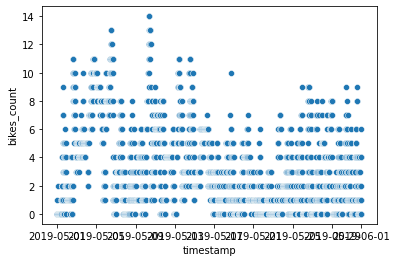

In [ ]:
sns.scatterplot(data = occu_df[occu_df.place == 'Plac Grunwaldzki / Polaka'], x = 'timestamp', y = 'bikes_count')

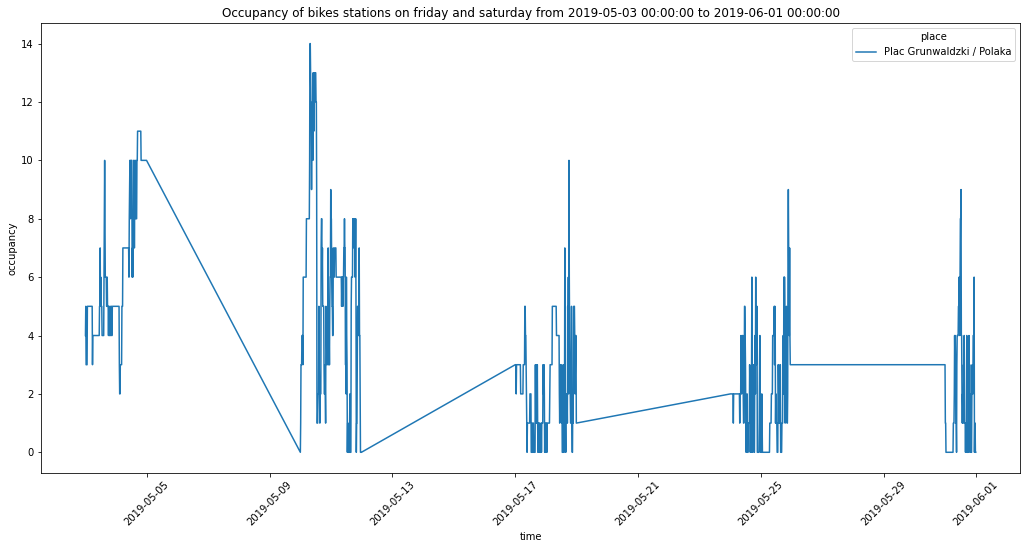

In [ ]:
temp_df = occu_df.loc[(occu_df.place.isin(['Plac Grunwaldzki / Polaka'])) & (occu_df.day_of_week.isin(range(4,6)))]
fig, ax = plt.subplots(figsize = (11.7 * 1.5, 8.27))
ax = sns.lineplot(ax = ax, data = temp_df, x = 'timestamp', y = 'bikes_count', hue = 'place')
ax.set_title(f'Occupancy of bikes stations on friday and saturday from {temp_df.timestamp.min()} to {temp_df.timestamp.max()}')
ax.set(xlabel = 'time', ylabel = 'occupancy')
ax.tick_params(axis = 'x', rotation=45)

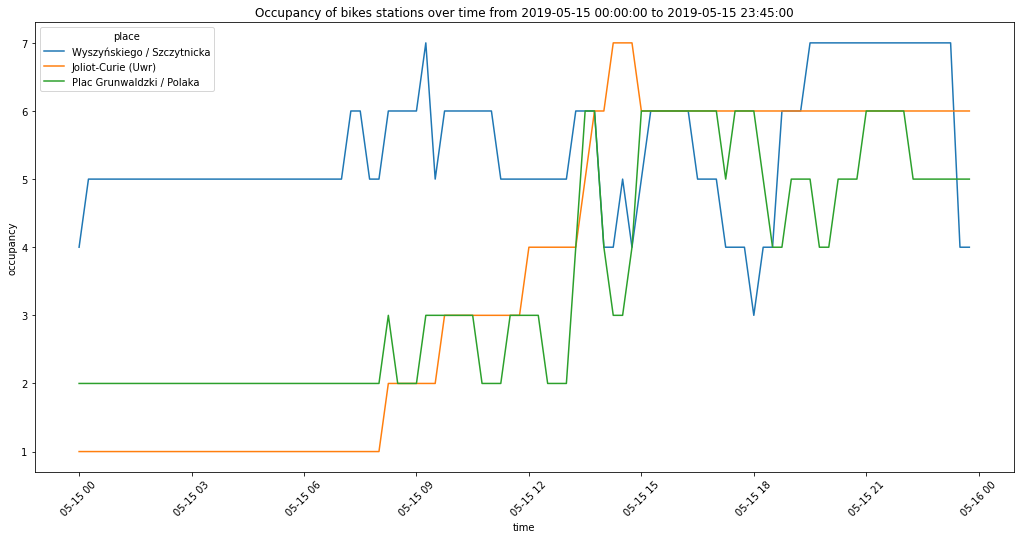

In [ ]:
temp_df = occu_df.loc[(occu_df.place.isin(['Wyszyńskiego / Szczytnicka', 'Joliot-Curie (Uwr)', 'Plac Grunwaldzki / Polaka'])) & (occu_df.day_of_month == 15)]
fig, ax = plt.subplots(figsize = (11.7 * 1.5, 8.27))
ax = sns.lineplot(ax = ax, data = temp_df, x = 'timestamp', y = 'bikes_count', hue = 'place')
ax.set_title(f'Occupancy of bikes stations over time from {temp_df.timestamp.min()} to {temp_df.timestamp.max()}')
ax.set(xlabel = 'time', ylabel = 'occupancy')
# ax.xaxis.set_major_locator(mdates.HourLocator())
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.tick_params(axis = 'x', rotation=45)

# Notes

### 1. Occupancy numbers are highly skewed towards 0

Example from March 2019:

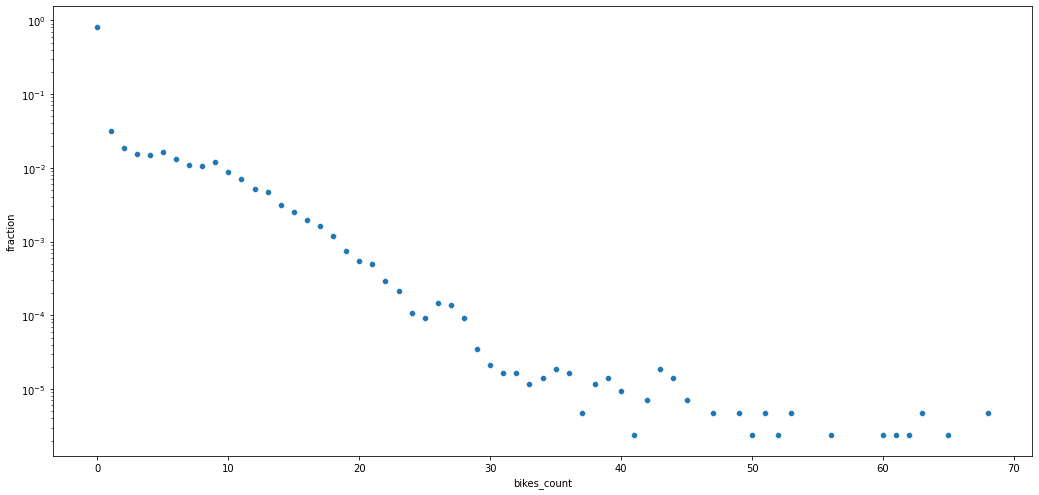

In [ ]:
df = get_data('03_2019')
occu_df = make_occupancy_df(df, one_hot_encode=False)

fractions = occu_df.bikes_count.value_counts() / len(occu_df.bikes_count)
frac_df = pd.DataFrame(fractions).reset_index().rename(columns = { 'index': 'bikes_count', 'bikes_count': 'fraction' })

fig, ax = plt.subplots(figsize = (11.7 * 1.5, 8.27))
g = sns.scatterplot(ax = ax, data = frac_df, x = 'bikes_count', y = 'fraction')
g.set_yscale("log")

# Known issues with source data

## 1. Station names

In [ ]:
def missing_places(key, clean_up_places = False):
    df = get_data(key, clean_up_places = clean_up_places)
    df_nona = get_data(key, place_as_categorical = False, clean_up_places = clean_up_places)
    missing_places = pd.concat([ df_nona.loc[df.rental_place.isna()].rental_place, df_nona.loc[df.return_place.isna()].return_place ]).value_counts()

    return missing_places

In [ ]:
"; ".join(sorted(list(missing_places('09_2019', clean_up_places = True).index)))

"#rowery zapasowe warszawa; .gotowe do rezerwacji; .relokacyjna; .relokacyjna a1-4; aquapark; berenta / kasprowicza; braci niemojowskich/szkoła; bułgarska; cmentarz tyniecki; dworzec pkp; fabryczna\xa0 (wsb); kozi borek; krzycka / aleja karkonoska (park południowy); ks. jolanty/most; mahle; majkowskie wembley; osobowicka / ostrowska; osobowicka / pętla tramwajowa; park przyjaźni; pl. inwalidów wojennych; pl. jana pawła ii/pomnik a. asnyka; podmiejska/orlik; poza stacją; pruślin szkoła; robotnicza / fabryczna; sadowa/mcdonald's; stawiszyńska/morelowa; strachowskiego / parafialna; targowisko; teatr; traktatowa (przystanek kolejowy); wilczak"

### 1.1 Stations from different cities.

Some rental information includes stations that are not from Wrocław. For instance, visible above "Cmentarz Tyniecki" station is not in Wrocław (most likely in Kalisz).

### 1.2 Station name changes
Some stations change their names over time. This impacts mostly old data from years 2015 and 2016. However, data from March 2019 to January 2020 is slightly impacted by this issue.

For some of the stations, names differ only slightly. However, due to the fact that we can't be certain that these stations are really in the same place, or it would require significat effort to verify), the best option is to ignore this fact.

In [ ]:
def normalize_occu_df(occu_df):
    """
    Ensures that the occupancy data frame has columns for all places, months, days of months and days of week.
    Additionaly makes sanity check for required columns.
    """
    
    places = [ (f'place_{place}', False, np.bool) for place in sorted(place_series) ]
    months = [ (f'month_{i}', False, np.bool) for i in range(1, 12+1) ]
    days_of_month = [ (f'days_of_month_{i}', False, np.bool) for i in range(1, 31+1) ]
    days_of_week = [ (f'days_of_week_{i}', False, np.bool) for i in range(0, 6+1) ]
    required = [ 'bikes_count', 'time_in_seconds', 'temperature', 'relative_humidity', 'wind_speed' ]
    
    for req in required:
        if req not in occu_df:
            print("Provided occu_df lacks basic columns!")
            return None
    
    checked_columns = months + days_of_month + days_of_week + places
    for (col, val, dtype) in checked_columns:
        if col not in occu_df:
            occu_df[col] = val
            
    astype = { col: dtype for (col, val, dtype) in checked_columns }
    occu_df = occu_df.astype(astype)
    
    all_columns = required + [ col for (col, val, dtype) in checked_columns ]
    
    return occu_df.reindex(all_columns, axis = 1)

def read_csv_with_cast(path):
    """
    Read CSV data from given path. Converts columns to proper types (thus making memory usage smaller).
    """
    
    places = [ (f'place_{place}', False, np.bool) for place in sorted(place_series) ]
    months = [ (f'month_{i}', False, np.bool) for i in range(1, 12+1) ]
    days_of_month = [ (f'days_of_month_{i}', False, np.bool) for i in range(1, 31+1) ]
    days_of_week = [ (f'days_of_week_{i}', False, np.bool) for i in range(0, 6+1) ]
    required = [ 'bikes_count', 'time_in_seconds', 'temperature', 'relative_humidity', 'wind_speed' ]
    checked_columns = months + days_of_month + days_of_week + places
    all_columns = required + [ col for (col, val, dtype) in checked_columns ]
    
    astype = { col: dtype for (col, val, dtype) in checked_columns }
    
    return pd.read_csv(path, dtype = astype).reindex(all_columns, axis = 1)

def pred_stats(model, X, y):
    """
    Generate prediction statistics for given model and data.
    """
    
    y_pred = model.predict(X)

    return {
        'score': model.score(X, y),
        'mse': mean_squared_error(y, y_pred),
        'mse_max': mean_squared_error(y, np.maximum(0, y_pred).round()),
        'true_false': (y >= np.maximum(0, y_pred).round()).value_counts() / len(y) # fix
    }

def make_roll(occu_dfs, train_sets, test_sets):
    """
    Split given dictionary of occupancy dataframes according to two given dictionary key sets.
    Used for evaluation of rolling training.
    """
    train_name = f'rolling_{len(train_sets)}_train__15min__8am_to_8pm__meteo_1hot.csv'
    train_occu_dfs = { key: occu_dfs[key] for key in train_sets }.values()
    pd.concat(train_occu_dfs).reset_index(drop = True).to_csv(train_name, index = False)
    
    test_name = f'rolling_{len(train_sets)}_test__15min__8am_to_8pm__meteo_1hot.csv'
    test_occu_dfs = { key: occu_dfs[key] for key in test_sets }.values()
    pd.concat(test_occu_dfs).reset_index(drop = True).to_csv(test_name, index = False)

#Bikes number prediction

## Random forest on May to September, 15min intervals and limited to 8am-8pm

SKLearn's RandomForest doesn't support categorical columns, so conversion to 1-hot is required

In [ ]:
sets = [ '05_2019', '06_2019', '07_2019', '08_2019', '09_2019' ]
%time meteo_data = { key: get_meteo(key) for key in sets }

# Variant for 1-hot-encoding
%time occu_dfs = { key: normalize_occu_df(make_occupancy_df(get_data(key), weather = meteo_data[key], freq = '15min', hours_limit = (8, 20), one_hot_encode = True, show_weekends = False)) for key in sets }

df = pd.concat(occu_dfs.values()).reset_index(drop = True)
#%time df.to_csv('dataset_15min__8am_to_8pm_meteo_1hot.csv', index = False)

CPU times: user 42.8 ms, sys: 3 ms, total: 45.8 ms
Wall time: 8.53 s
CPU times: user 2min 4s, sys: 1.54 s, total: 2min 5s
Wall time: 2min 6s


In [ ]:
X, y = df.drop(columns = ['bikes_count']), df.bikes_count
%time X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.67, random_state = 42)

CPU times: user 3.4 s, sys: 8.99 ms, total: 3.41 s
Wall time: 3.41 s


In [ ]:
X_train.to_csv("X_train.csv")

In [ ]:
rfms_model = sklearn.ensemble.RandomForestRegressor(n_estimators = 20, n_jobs = 2)
%time rfms_model.fit(X_train, y_train)

CPU times: user 1h 29min 49s, sys: 4.69 s, total: 1h 29min 53s
Wall time: 45min 37s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=20, n_jobs=2, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
%time pred_stats(rfms_model, X_train, y_train)

CPU times: user 1min 39s, sys: 4.33 s, total: 1min 43s
Wall time: 1min 6s


{'mse': 0.48415323058187537,
 'mse_max': 0.5180363992875577,
 'score': 0.9824999782088503,
 'true_false': True     0.884631
 False    0.115369
 Name: bikes_count, dtype: float64}

In [ ]:
%time pred_stats(rfms_model, X_test, y_test)

CPU times: user 48.8 s, sys: 108 ms, total: 48.9 s
Wall time: 30.5 s


{'mse': 2.8859334160670738,
 'mse_max': 2.947478514024387,
 'score': 0.8962801296167704,
 'true_false': True     0.746885
 False    0.253115
 Name: bikes_count, dtype: float64}

In [ ]:
X_train_no_date = X_train.drop(columns = list(df.filter(regex='month')))
X_test_no_date = X_test.drop(columns = list(df.filter(regex='month')))
X_train_no_meteo = X_train.drop(columns = ['temperature', 'relative_humidity', 'wind_speed'])
X_test_no_meteo = X_test.drop(columns = ['temperature', 'relative_humidity', 'wind_speed'])

In [ ]:
rfms_model_no_date = sklearn.ensemble.RandomForestRegressor(n_estimators = 20, n_jobs = 2)
%time rfms_model_no_date.fit(X_train_no_date, y_train)

CPU times: user 1h 15min 24s, sys: 3.09 s, total: 1h 15min 27s
Wall time: 38min 34s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=20, n_jobs=2, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
rfms_model_no_meteo = sklearn.ensemble.RandomForestRegressor(n_estimators = 20, n_jobs = 2)
%time rfms_model_no_meteo.fit(X_train_no_meteo, y_train)

CPU times: user 1h 11min 24s, sys: 3.06 s, total: 1h 11min 27s
Wall time: 36min 24s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=20, n_jobs=2, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
%time pred_stats(rfms_model_no_date, X_train_no_date, y_train)

CPU times: user 1min 44s, sys: 1.74 s, total: 1min 46s
Wall time: 1min 5s


{'mse': 0.6893687097398835,
 'mse_max': 0.7282360280121902,
 'score': 0.975082598016779,
 'true_false': True     0.868098
 False    0.131902
 Name: bikes_count, dtype: float64}

In [ ]:
%time pred_stats(rfms_model_no_date, X_test_no_date, y_test)

CPU times: user 48.9 s, sys: 98.8 ms, total: 49 s
Wall time: 29.8 s


{'mse': 4.093100782707269,
 'mse_max': 4.158846261850956,
 'score': 0.853512891264759,
 'true_false': True     0.725438
 False    0.274562
 Name: bikes_count, dtype: float64}

In [ ]:
%time pred_stats(rfms_model_no_meteo, X_train_no_meteo, y_train)

CPU times: user 1min 21s, sys: 3.03 s, total: 1min 24s
Wall time: 55.9 s


{'mse': 13.691771209031884,
 'mse_max': 13.758354871883654,
 'score': 0.5051075538278071,
 'true_false': True     0.588386
 False    0.411614
 Name: bikes_count, dtype: float64}

In [ ]:
%time pred_stats(rfms_model_no_meteo, X_test_no_meteo, y_test)

CPU times: user 40.9 s, sys: 98.9 ms, total: 41 s
Wall time: 26.6 s


{'mse': 15.259619759893301,
 'mse_max': 15.323383274655622,
 'score': 0.45387673118876365,
 'true_false': True     0.583353
 False    0.416647
 Name: bikes_count, dtype: float64}

In [ ]:
y_test

560896      5
903401      1
437963      6
1256593     1
135079      0
           ..
12264       0
1167283     3
1017198    22
524815      0
146351      0
Name: bikes_count, Length: 523481, dtype: int64

In [ ]:
for k in range(50):
    print(rfms_model_no_date.predict(X_test_no_date.iloc[k, ].to_numpy().reshape(1, -1))[0], '\t:\t', y_test.iloc[k])

7.15 	:	 5
2.0 	:	 1
4.55 	:	 6
1.4 	:	 1
0.0 	:	 0
4.4 	:	 4
15.7 	:	 18
0.0 	:	 0
0.0 	:	 0
3.65 	:	 2
3.6 	:	 6
0.0 	:	 0
0.95 	:	 2
2.05 	:	 2
0.0 	:	 0
0.0 	:	 0
0.0 	:	 0
4.95 	:	 7
0.0 	:	 0
0.0 	:	 0
1.7 	:	 1
2.15 	:	 3
1.8 	:	 2
2.7 	:	 2
2.5 	:	 0
4.55 	:	 0
0.0 	:	 0
3.25 	:	 6
12.45 	:	 16
0.65 	:	 0
10.1 	:	 0
13.5 	:	 11
0.25 	:	 0
2.85 	:	 4
2.2 	:	 4
10.85 	:	 12
9.2 	:	 9
3.6 	:	 4
0.0 	:	 0
0.0 	:	 0
3.6 	:	 3
0.0 	:	 0
8.05 	:	 12
0.0 	:	 0
2.3 	:	 1
1.55 	:	 3
4.75 	:	 5
3.3 	:	 6
9.2 	:	 10
7.2 	:	 8
